In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE

# Load the datasets
daily_data = pd.read_csv('data/AAPL_daily.csv')
sentiment_data = pd.read_csv('AAPL_monthly_sentiment2.csv')

# Rename the 'time published' column to 'Date' for easy merging
sentiment_data = sentiment_data.rename(columns={'Time Published': 'Date'})

sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], format='%Y%m%dT%H%M%S').dt.strftime('%Y-%m-%d')

# Merge the datasets on 'Date'
merged_data = pd.merge(daily_data, sentiment_data, on='Date')

# Create volatility feature
merged_data['Volatility'] = merged_data['High'] - merged_data['Low']

# Create daily price change feature
merged_data['Daily_Change'] = merged_data['Close'] - merged_data['Open']

# Create 5-day moving average of close prices
merged_data['MA_5'] = merged_data['Close'].rolling(window=5).mean()

# Create Relative Strength Index (RSI)
window_length = 14
close = merged_data['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up1 = up.rolling(window_length).mean()
roll_down1 = down.abs().rolling(window_length).mean()
RS = roll_up1 / roll_down1
merged_data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

# Shift the sentiment score one day forward
merged_data['Overall Sentiment Score'] = merged_data['Overall Sentiment Score'].shift(1)

# After shifting, you will have one row with NaN for the sentiment score, so drop that
merged_data = merged_data.dropna()

# Create a target variable: 1 if the stock price rose during the day, 0 otherwise
merged_data['Target'] = (merged_data['Close'] - merged_data['Open'] > 0).astype(int)

# Drop rows with NaN values (due to diff() and shift() operations)
merged_data = merged_data.dropna()

# Split the data into training and test sets
train_set, test_set = train_test_split(merged_data, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train = train_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']]
y_train = train_set['Target']
X_resampled, y_resampled = X_train, y_train

# Feature scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(test_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']])
y_test = test_set['Target'].values

# Neural Network with L2 regularization and Dropout
model = Sequential([
    Dense(10, input_dim=5, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights for imbalanced data
class_weights = {
    0: (1 / y_train[y_train == 0].shape[0]) * (train_set.shape[0] / 2.0),
    1: (1 / y_train[y_train == 1].shape[0]) * (train_set.shape[0] / 2.0)
}

# Train the model with class weights
model.fit(
    X_resampled, 
    y_resampled, 
    epochs=50, 
    batch_size=30, 
    validation_data=(X_test, y_test),
    class_weight=class_weights  # Add class weights
)
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50
52/52 [==============================] - 1s 5ms/step - loss: 1.0668 - accuracy: 0.5347 - val_loss: 0.7765 - val_accuracy: 0.6221
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 0.9274 - accuracy: 0.5347 - val_loss: 0.7419 - val_accuracy: 0.6838
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8702 - accuracy: 0.5585 - val_loss: 0.7230 - val_accuracy: 0.7609
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8097 - accuracy: 0.5861 - val_loss: 0.7089 - val_accuracy: 0.8123
Epoch 5/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7854 - accuracy: 0.5835 - val_loss: 0.6927 - val_accuracy: 0.8586
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7624 - accuracy: 0.6125 - val_loss: 0.6749 - val_accuracy: 0.8792
Epoch 7/50
52/52 [==============================] - 0s 2ms/step - loss: 0.7384 - accuracy: 0.6183 - val_loss: 0.6517 - val_accuracy: 0.8946
Epoch 8/50
52/52 [==

In [31]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).reshape(X_test.shape[0])



13/13 [==============================] - 0s 665us/step


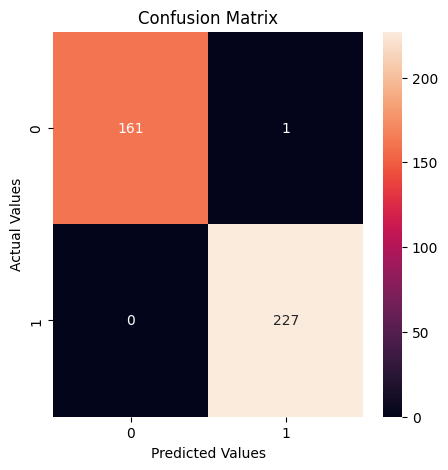

In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()



In [16]:
# predict with user input
def predict_sentiment_score(sentiment_score):
    sentiment_score = np.array(sentiment_score).reshape(1, 1)
    sentiment_score = scaler.transform(sentiment_score)
    prediction = model.predict(sentiment_score)
    prediction = (prediction > 0.5).astype(int).reshape(sentiment_score.shape[0])
    if prediction == 1:
        return 'The stock price will rise compared to the previous day.'
    else:
        return 'The stock price will fall compared to the previous day.'
    


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

def preprocess_data(stock_daily_file, sentiment_file):
    # Load the datasets
    daily_data = pd.read_csv(stock_daily_file)
    sentiment_data = pd.read_csv(sentiment_file)
    
    # Rename the 'time published' column to 'Date' for easy merging
    sentiment_data = sentiment_data.rename(columns={'Time Published': 'Date'})
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], format='%Y%m%dT%H%M%S').dt.strftime('%Y-%m-%d')
    
    # Merge the datasets on 'Date'
    merged_data = pd.merge(daily_data, sentiment_data, on='Date')
    
    # Create target variable
    merged_data['Target'] = (merged_data['Close'].diff() > 0).astype(int).shift(-1)
    merged_data = merged_data.dropna()

    # Split the data into training and test sets
    train_set, test_set = train_test_split(merged_data, test_size=0.2, random_state=42)

    # Oversample using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train_set[['Overall Sentiment Score']], train_set['Target'])

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_set[['Overall Sentiment Score']])
    X_test = scaler.transform(test_set[['Overall Sentiment Score']])
    y_train = train_set['Target'].values
    y_test = test_set['Target'].values

    return X_resampled, y_resampled, X_test, y_test

def build_and_train_model(X_resampled, y_resampled, X_test, y_test):
    # Neural Network model
    model = Sequential([
        Dense(10, input_dim=1, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    class_weights = class_weight.compute_class_weight('balanced', classes=[0.0, 1.0], y=y_resampled)

    model.fit(X_resampled, y_resampled, epochs=50, batch_size=20, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    return accuracy, model

# Files for 4 different stocks (Example: Replace with actual file paths)
stocks_daily_files = ['data/AAPL_daily.csv', 'data/nvda_daily.csv', 'data/jpm_daily.csv', 'data/xom_daily.csv', 'data/jnj_daily.csv']
sentiment_files = ['AAPL_monthly_sentiment2.csv', 'nvda_monthly_sentiment2.csv', 'jpm_monthly_sentiment2.csv', 'xom_monthly_sentiment2.csv', 'jnj_monthly_sentiment2.csv']

# Train models for each stock
models = []
for stock_daily_file, sentiment_file in zip(stocks_daily_files, sentiment_files):
    X_resampled, y_resampled, X_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    accuracy, model = build_and_train_model(X_resampled, y_resampled, X_test, y_test)
    print(f"Accuracy for {stock_daily_file}: {accuracy * 100:.2f}%")
    models.append(model)


Epoch 1/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6890 - accuracy: 0.5378 - val_loss: 0.6254 - val_accuracy: 0.4900
Epoch 2/50
393/393 [==============================] - 0s 982us/step - loss: 0.6848 - accuracy: 0.5587 - val_loss: 0.6037 - val_accuracy: 0.4820
Epoch 3/50
393/393 [==============================] - 0s 1ms/step - loss: 0.6830 - accuracy: 0.5611 - val_loss: 0.6084 - val_accuracy: 0.4621
Epoch 4/50
393/393 [==============================] - 1s 1ms/step - loss: 0.6822 - accuracy: 0.5588 - val_loss: 0.5407 - val_accuracy: 0.4850
Epoch 5/50
393/393 [==============================] - 1s 1ms/step - loss: 0.6814 - accuracy: 0.5587 - val_loss: 0.5165 - val_accuracy: 0.6277
Epoch 6/50
393/393 [==============================] - 0s 1ms/step - loss: 0.6809 - accuracy: 0.5579 - val_loss: 0.4748 - val_accuracy: 0.7535
Epoch 7/50
393/393 [==============================] - 0s 991us/step - loss: 0.6805 - accuracy: 0.5600 - val_loss: 0.4458 - val_accuracy: 0.8004
Ep

9/9 [==============================] - 0s 994us/step


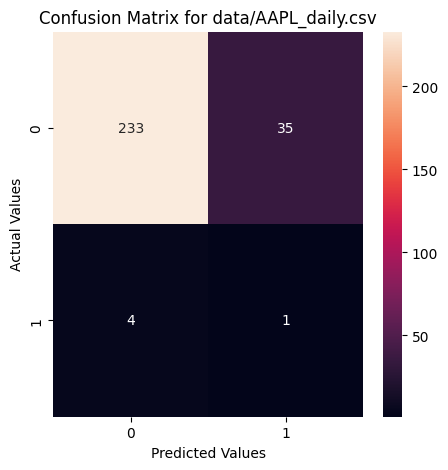

9/9 [==============================] - 0s 851us/step


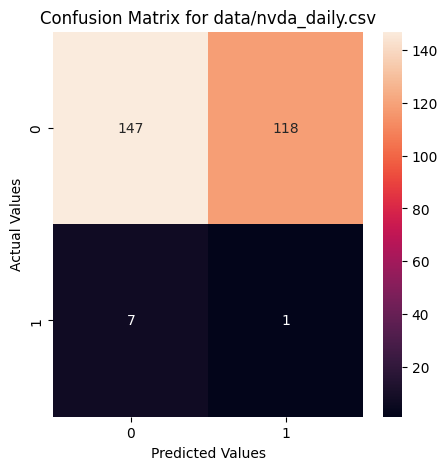

9/9 [==============================] - 0s 827us/step


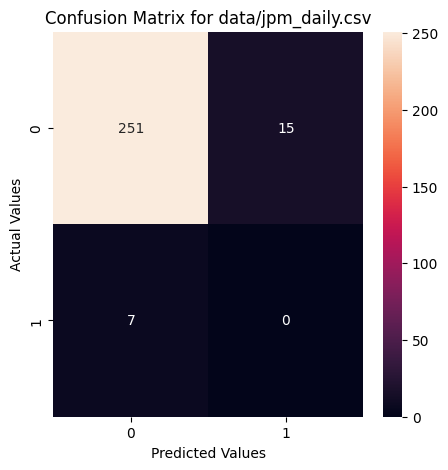

9/9 [==============================] - 0s 1ms/step


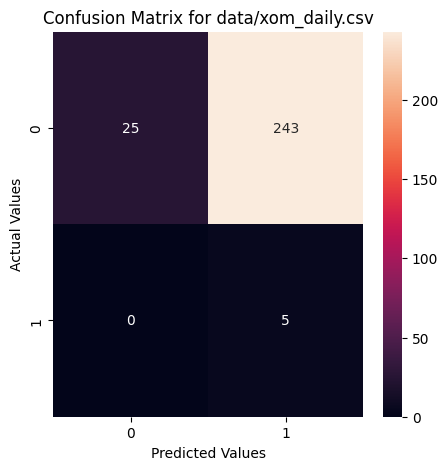

9/9 [==============================] - 0s 791us/step


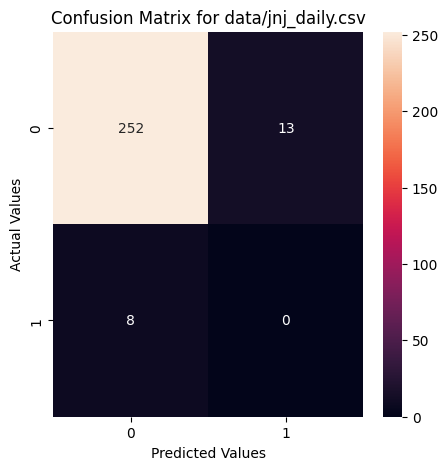

In [18]:
# for each stock plot a confusion matrix
for model, stock_daily_file in zip(models, stocks_daily_files):
    X_resampled, y_resampled, X_test, y_test = preprocess_data(stock_daily_file, sentiment_file)
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int).reshape(X_test.shape[0])
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {stock_daily_file}")
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()